# Data Shuffling and Stratified Train-Val-Test Split Sample Implementation

### Import Libraries

In [1]:
import os
import numpy as np
import pandas as pd
from PIL import Image
from io import StringIO
from matplotlib import pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torchvision.utils import make_grid
from torch.utils.data import Dataset, DataLoader, Subset
from sklearn.model_selection import train_test_split

C:\Users\Irish\anaconda3\envs\conv_env\lib\site-packages\torchvision\io\image.py:13: UserWarning: Failed to load image Python extension: [WinError 127] The specified procedure could not be found
  warn(f"Failed to load image Python extension: {e}")


### Define Variables & Helper Functions

In [2]:
# Set seed for random number generation to create reproducible results
random_seed = 5
torch.manual_seed(random_seed)

In [3]:
# Transformations to apply to inputs
preprocess = transforms.Compose([
    # Convert PIL Image to tensor and scale to [0, 1] through max normalization
    # (i.e. for every pixel in image, new_pixel_value = pixel/255)
    transforms.ToTensor()
])

In [4]:
# Helper function to get ground truth class of an image
def get_img_labels(img_dir):
    labels = ''
    
    for filename in os.listdir(img_dir):
        # If image has no metastasis
        if (filename[5] == '0'):
            labels += filename + ",0\n"
            
        # If image has metastasis
        else:
            labels += filename + ",1\n"
        
    return labels

### Load Data

In [5]:
# Image dataset
class CustomDataset(Dataset):
    def __init__(self, img_dir, transform):
        self.img_dir = img_dir
        self.img_labels = pd.read_csv(StringIO(get_img_labels(img_dir)), sep=",", header=None)
        self.transform = transform

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        # Generate image filepath
        filename = self.img_labels.iloc[idx, 0]
        img_path = self.img_dir + "/" + filename
        
        # Read and transform image
        image = Image.open(img_path).convert("RGB")
        image = self.transform(image)
        
        # Determine ground truth class (metastasis or no metastasis)
        label = self.img_labels.iloc[idx, 1]
        return image, label, filename

In [6]:
# Dataset and dataloader for training data
dataset = CustomDataset(img_dir=r"dataset-augmented", transform=preprocess)

### Data Shuffling & Train-Val-Test Split

In [7]:
# Get classes and indices of images
labels = list(dataset.img_labels.iloc[:, 1])
indices = np.arange(len(labels))

In [8]:
# Split dataset into 70% training, 10% validation, and 20% test with shuffle and stratified split
# Split dataset into training and test sets
train_indices, test_indices = train_test_split(indices, 
                                       train_size=0.8, 
                                       random_state=random_seed, # TODO: Change so that every epoch, random_seed += 1
                                       shuffle=True, 
                                       stratify=labels)

# Split training set into training and validation sets
train_labels = [labels[i] for i in train_indices]
train_indices, val_indices = train_test_split(train_indices, 
                                      train_size=0.875,
                                      random_state=random_seed, 
                                      shuffle=True, 
                                      stratify=train_labels)

# Check that dataset was split into 70% training, 10% validation, and 20% test
print(f"Images in training set: {len(train_indices)} ({(len(train_indices)*100/len(indices)):.2f}% of total dataset)")
print(f"Images in validation set: {len(val_indices)} ({(len(val_indices)*100/len(indices)):.2f}% of total dataset)")
print(f"Images in test set: {len(test_indices)} ({(len(test_indices)*100/len(indices)):.2f}% of total dataset)")
print("-" * 10)
print(f"Total images in dataset: {len(indices)}")

Images in training set: 1715 (69.97% of total dataset)
Images in validation set: 245 (10.00% of total dataset)
Images in test set: 491 (20.03% of total dataset)
----------
Total images in dataset: 2451


In [9]:
# Check that training, validation, and test sets have the same ratio of non-metastasis to metastasis as the whole dataset
train_labels = [labels[i] for i in train_indices]
val_labels = [labels[i] for i in val_indices]
test_labels = [labels[i] for i in test_indices]

train_classes, train_counts = np.unique(train_labels, return_counts=True)
val_classes, val_counts = np.unique(val_labels, return_counts=True)
test_classes, test_counts = np.unique(test_labels, return_counts=True)
dataset_classes, dataset_counts = np.unique(labels, return_counts=True)

print(f"Classes in training set:")
print(f"{train_counts[0]} without metastasis ({(train_counts[0]*100/len(train_indices)):.2f}% of training set)")
print(f"{train_counts[1]} with metastasis ({(train_counts[1]*100/len(train_indices)):.2f}% of training set)\n")
print(f"Classes in validation set:")
print(f"{val_counts[0]} without metastasis ({(val_counts[0]*100/len(val_indices)):.2f}% of validation set)")
print(f"{val_counts[1]} with metastasis ({(val_counts[1]*100/len(val_indices)):.2f}% of validation set)\n")
print(f"Classes in test set:")
print(f"{test_counts[0]} without metastasis ({(test_counts[0]*100/len(test_indices)):.2f}% of test set)")
print(f"{test_counts[1]} with metastasis ({(test_counts[1]*100/len(test_indices)):.2f}% of test set)")
print("-" * 10)
print(f"Total classes in dataset:")
print(f"{dataset_counts[0]} without metastasis ({(dataset_counts[0]*100/len(indices)):.2f}% of dataset)")
print(f"{dataset_counts[1]} with metastasis ({(dataset_counts[1]*100/len(indices)):.2f}% of dataset)")

Classes in training set:
1117 without metastasis (65.13% of training set)
598 with metastasis (34.87% of training set)

Classes in validation set:
160 without metastasis (65.31% of validation set)
85 with metastasis (34.69% of validation set)

Classes in test set:
320 without metastasis (65.17% of test set)
171 with metastasis (34.83% of test set)
----------
Total classes in dataset:
1597 without metastasis (65.16% of dataset)
854 with metastasis (34.84% of dataset)


In [10]:
# Get training, validation, and test sets
train_set = Subset(dataset, train_indices)
val_set = Subset(dataset, val_indices)
test_set = Subset(dataset, test_indices)

In [11]:
# Load training, validation, and test sets
batch_size = 10

train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_set, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=True)

Classes: 0 1 0 0 1 1 0 0 1 0


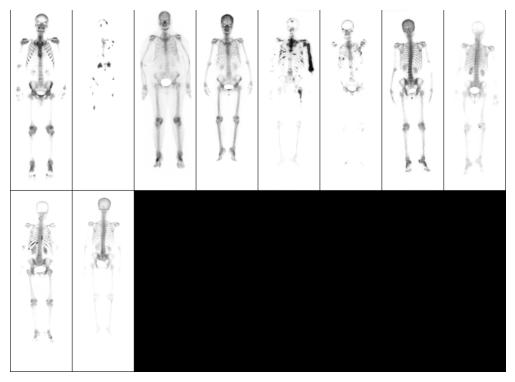

In [14]:
# Show random images from training data and their ground truth classes
dataiter = iter(train_loader)
images, labels, filenames = next(dataiter)

plt.axis('off')
plt.imshow(make_grid(images).permute(1,2,0))
print("Classes: " + ' '.join(f'{labels[j]}' for j in range(len(labels))))

### Define Model

In [ ]:
# Create model with CNN and MLP for classification
class CustomModel(nn.Module):
    
    # Define layers
    def __init__(self):
        super().__init__()
        self.conv = nn.Conv2d(in_channels = 1, out_channels = 1, kernel_size = 5)
        self.pool = nn.MaxPool2d(kernel_size = 2)
        self.fc1 = nn.Linear(in_features = 1 * 158 * 52, out_features = 200)
        self.fc2 = nn.Linear(in_features = 200, out_features = 100)
        self.fc3 = nn.Linear(in_features = 100, out_features = 2)

    # Apply layers
    def forward(self, x):
        # CNN layers for convoltion
        x = self.pool(F.relu(self.conv(x)))
        x = self.pool(F.relu(self.conv(x)))
        # Flatten all dimensions except batch
        x = torch.flatten(input = x, start_dim = 1)
        # MLP layers for classification
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = F.softmax(input = x, dim = 1)
        return x

In [ ]:
# Allocate tensors to the device used for computation
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Performing torch operations on {device} device")

In [ ]:
# Instantiate model
model = CustomModel()

In [ ]:
# Define criterion (function used to compute loss) and optimizer for model
criterion = nn.CrossEntropyLoss()
criterion = criterion.to(device)
optimizer = optim.Adam(model.parameters(), lr=0.0001)

### Train Model

In [ ]:
epochs = 100
losses = []

In [ ]:
# Train model
for epoch in range(epochs):
    print(f"Epoch: {epoch}/{epochs-1}")
    running_loss = 0
    batch_count = 0
    
    for batch_index, batch_data in enumerate(trainloader, 0):
        # Get the inputs; data is a list of [images, labels]
        images, labels = batch_data

        # Forward pass
        predictions = model(images) # Pass input through model.forward()
        loss = criterion(predictions, labels) # Compute loss against ground truth labels
        
        # Backpropagation
        optimizer.zero_grad() # Reset gradients from previous passes
        loss.backward() # Compute gradients using derivative of loss
        optimizer.step() # Update values using gradients

        running_loss += loss.item() # Add batch loss to current epoch loss
        batch_count += 1 # Increment number of finished batches
    
    running_loss = running_loss / batch_count
    losses.append(running_loss)
    print("Loss: {}".format(running_loss))
    print("------------------")

### Evaluate Model

In [ ]:
# Plot losses
ax = plt.axes()
plt.plot(losses, color='red')
plt.title('Training Loss Evaluation')
ax.set_xticks([x for x in range(epochs)])
plt.xlabel('Epoch')
plt.ylabel('Magnitude')
plt.show()

### Test Model on Test Dataset

In [ ]:
# Dataset and dataloader for test data
testset = CustomDataset(img_dir=r"dataset-sample\test", transform=transform)
testloader = DataLoader(testset, batch_size=batch_size, shuffle=True)

In [ ]:
# Show sample images from test data and their ground truth classes
dataiter = iter(testloader)
images, labels = next(dataiter)

plt.axis('off')
plt.imshow(make_grid(images).permute(1,2,0))
print("Actual Classes: " + ' '.join(f'{labels[j]}' for j in range(len(labels))))

In [ ]:
correct_predictions = 0
total_predictions = 0

print("Model predictions on test dataset:")

with torch.no_grad(): # Without updating gradients
    for data in testloader:
        images, labels = data
        outputs = model(images) # Pass input through model.forward()
        
        # Choose class with the highest probability as the prediction for that image
        _, predicted = torch.max(input = outputs.data, dim = 1)
        
        for index in range(predicted.size(dim=0)):
            print(f"Predictions: {outputs[index]}")
            print(f"Actual Class: {labels[index]}   Predicted Class: {predicted[index]}\n")
        
        total_predictions += labels.size(0)
        correct_predictions += (predicted == labels).sum().item()

print(f'Model accuracy on {total_predictions} test images: {100 * correct_predictions // total_predictions}%')